In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import colors as mcolors,cm,colorbar
import scipy
import shapefile
import re
import json

/Users/grisha.oryol/anaconda/envs/cloned/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


## Load election results

In [4]:
el_ak=pd.read_csv("2016_US_County_Level_Presidential_Results.csv")
el=el_ak[~((el_ak.state_abbr=='AK')& (el_ak.combined_fips!=2013))]
by_state=el.groupby('state_abbr')['votes_dem','votes_gop'].aggregate(sum)

## Compare with AP

In [7]:
fl=open('president.json')

In [8]:
fl_ap=open('president_ap.json')

In [9]:
js=json.load(fl)

In [10]:
js_ap=json.load(fl_ap)

In [11]:
data_ap=pd.DataFrame([{'id':x['id'],'cand1':x['vote'][0],'cand2':x['vote'][1],'state':x['st']} for x in js_ap['results']])

In [12]:
data_ap=data_ap[data_ap.id.apply(lambda x: x.isnumeric())]

In [13]:
data_ap['id']=[int(x) for x in data_ap.id]

In [14]:
[x for x in (data_ap.id.sort_values().values-el.combined_fips.sort_values().values) if x!=0]

[-13, -1, -2, -2, -2, -2, -2]

In [15]:
data_ap.columns=[u'cand1', u'cand2', u'combined_fips', u'state']

In [16]:
merged_ap=pd.merge(data_ap,el,on='combined_fips')
rat=pd.DataFrame({'r1':merged_ap['cand2']-merged_ap['votes_dem'],'r4':merged_ap['cand2']-merged_ap['votes_gop'],
'r3':merged_ap['cand2']-merged_ap['votes_gop'],'r2':merged_ap['cand2']-merged_ap['votes_dem']})

In [17]:
discr=pd.DataFrame([sorted(x,key=lambda x:abs(x))[:2] for i,x in rat.iterrows()])
discr.columns=['discr1','discr2']

In [18]:
del merged_ap[u'Unnamed: 0']

In [19]:
del merged_ap['state_abbr']

In [21]:
merged1=pd.concat([merged_ap,discr],axis=1)
np.mean(abs(merged1['discr1']/merged1['total_votes'])>0.05)

0.023143683702989394

## Shapefile for counties

In [23]:
sf=shapefile.Reader("cb_2015_us_county_5m.shp")
shapes=sf.shapes()
col_names=[x[0] for x in sf.fields][1:]
records=pd.DataFrame([dict(zip(*[col_names, x])) for x in sf.records()])

In [24]:
state_shapes_file=shapefile.Reader("cb_2015_us_state_5m.shp")
state_shapes=state_shapes_file.shapes()
state_col_names=[x[0] for x in state_shapes_file.fields][1:]
state_records=pd.DataFrame([dict(zip(*[state_col_names, x])) for x in state_shapes_file.records()])

In [25]:
print(el.votes_dem.sum(),el.votes_gop.sum())

(62521735.0, 61195256.0)


In [26]:
state_records['points']=[x.points for x in state_shapes]

In [27]:
outlying=[2,60,3,81,7,64,14,66,84,86,67,89,71,76,69,70,95,43,72,74,52,78,79,15]

In [28]:
palette=['b', 'g', 'r', 'c', 'm', 'y', 'k']

In [29]:
records['combined_fips']=[int(x.STATEFP+x.COUNTYFP) for i,x in records.iterrows()]

In [30]:
records['points']=[x.points for x in shapes]

In [32]:
merged=pd.merge(el[['combined_fips','per_dem']],
         records,on='combined_fips',how='inner'
)
#merged['per_dem'][merged.isnull()['per_dem']]=0

In [33]:
def draw_usa(merged,factor):
    fig=plt.figure(figsize=(20,10))
    max_val=merged[factor].max()
    min_val=merged[factor].min()
    sbp=fig.add_subplot(111)
    #ax=fig.add_axes([0,0,1,1])
    for i,row in merged[~pd.isnull(merged.STATEFP)].iterrows():
        if not (int(row.STATEFP) in outlying):
            per=(row[factor]-min_val)/(max_val-min_val)
            sbp.fill(*zip(*row.points),color=np.array([1,0,0])*(1-per)+np.array([0,0,1])*per)
            sbp.plot(*zip(*row.points),color='black')#palette[colors[i]%len(palette)])
    for i,row in state_records.iterrows():
        if not (int(row.STATEFP) in outlying):
            sbp.plot(*zip(*row.points),color='green')
    #cmap = cm.cool
    #norm = mcolors.Normalize(vmin=0, vmax=1)

# ColorbarBase derives from ScalarMappable and puts a colorbar
# in a specified axes, so it has everything needed for a
# standalone colorbar.  There are many more kwargs, but the
# following gives a basic continuous colorbar with ticks
# and labels.

    #cbaxes = fig.add_axes([0.8, 0.1, 0.03, 0.8]) 
    #cb1 = fig.colorbar(ax=ax,cax=cbaxes)
    fig.set_size_inches(fig.get_size_inches()*1)
    plt.show()

In [966]:
header

,1,0
0,,
PST120214,"Population, percent change - April 1, 2010 to ...",PST120214
AGE135214,"Persons under 5 years, percent, 2014",AGE135214
AGE295214,"Persons under 18 years, percent, 2014",AGE295214
AGE775214,"Persons 65 years and over, percent, 2014",AGE775214
SEX255214,"Female persons, percent, 2014",SEX255214
RHI225214,"Black or African American alone, percent, 2014",RHI225214
RHI425214,"Asian alone, percent, 2014",RHI425214
RHI625214,"Two or More Races, percent, 2014",RHI625214
RHI725214,"Hispanic or Latino, percent, 2014",RHI725214


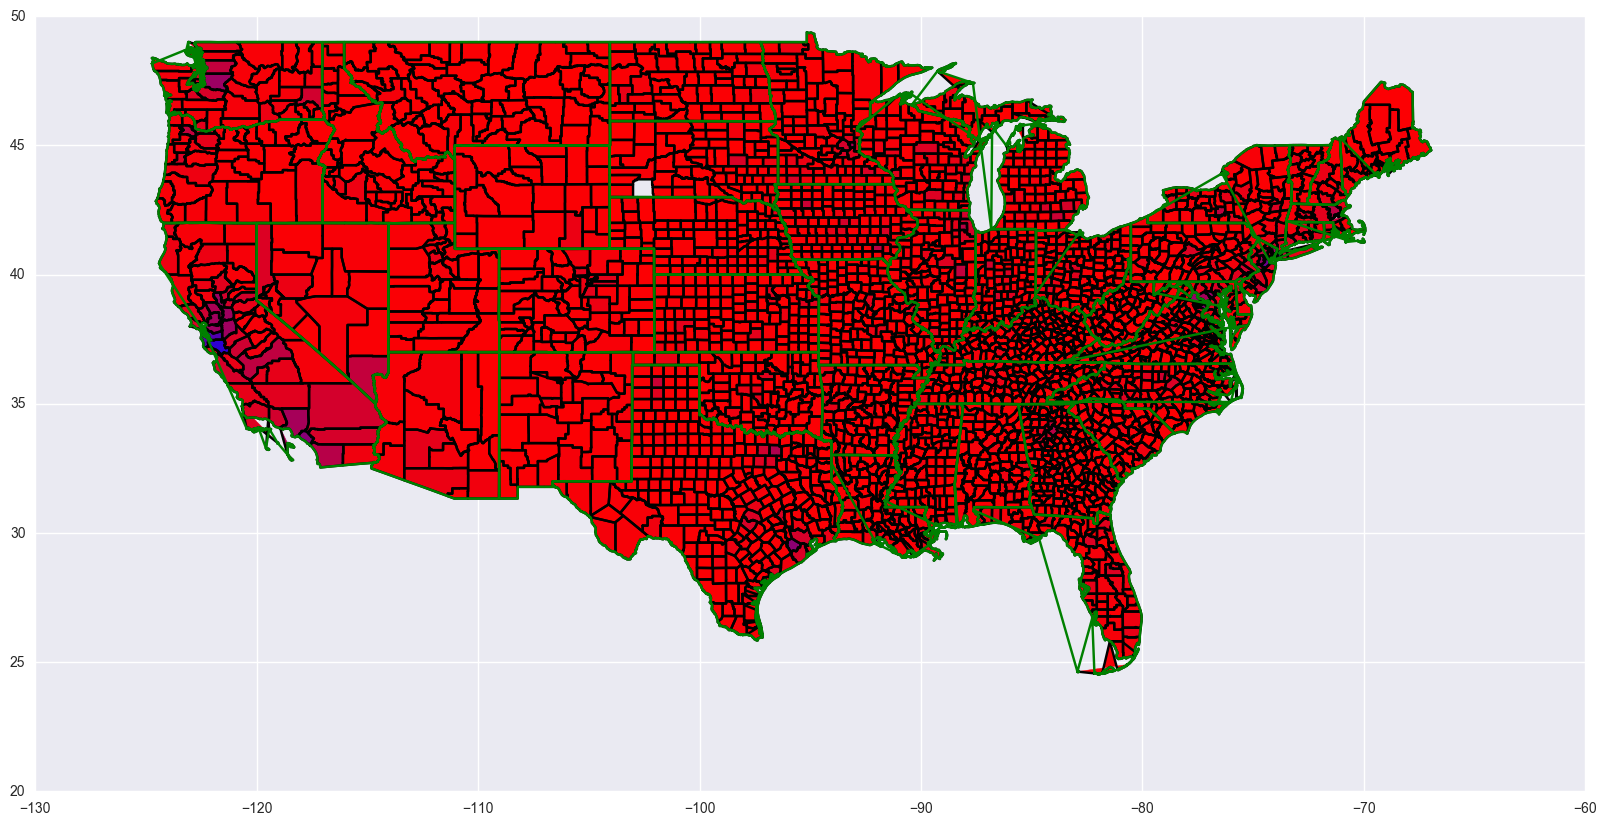

In [968]:
draw_usa(merged3,'RHI425214')

## Load Country facts

In [904]:
import sqlite3

In [905]:
conn=sqlite3.connect('database.sqlite')
curs=conn.cursor()
res=curs.execute("select name from sqlite_master where type='table'")
res.fetchall()

[(u'primary_results',), (u'county_facts',), (u'county_facts_dictionary',)]

In [906]:
res=curs.execute("select * from county_facts")
country_facts=pd.DataFrame(res.fetchall())
res=curs.execute("select * from county_facts_dictionary")
header=pd.DataFrame(res.fetchall())

In [907]:
lst=['combined_fips','name','abbr']
lst.extend(header[0].values)
country_facts.columns=lst

In [908]:
header=header.set_index(0)
header[0]=header.index

In [909]:
exclude=['PST040210','POP010210','LND110210','RTN130207','RHI125214','HSD410213',
         'RHI325214','RHI525214','SBO115207','SBO215207','SBO515207']
for x in exclude:
    country_facts=country_facts.drop(x,axis=1)
    header=header.drop(x)

In [910]:
header_percent=header[~header[1].apply(lambda x: re.search("percent|rate|pct",x) is None)]
header_extensive=header[header[1].apply(lambda x: re.search("percent|rate|minutes|median|Median|per |Per |pct",x) is None)]
header_extensive=header_extensive.drop('PST045214')

In [911]:

for i,x in header.iterrows():
    country_facts[x[0]]=country_facts[x[0]].astype(float)
for i,x in header_percent.iterrows():
    country_facts[x[0]]=country_facts[x[0]]/100.0

for i,x in header_extensive.iterrows():
    country_facts[x[0]]=country_facts[x[0]]/country_facts['PST045214']

In [912]:
#header['percent_zeros']=[np.mean(merged3[x]==0) for x in header[0]]
    

## Prediction model

In [921]:
merged2=pd.merge(merged[['combined_fips','STATEFP','per_dem']],country_facts,on='combined_fips')
merged3=pd.merge(merged2,records,on='combined_fips')
merged3['STATEFP']=merged3.STATEFP_x
merged3.drop('PST045214',axis=1,inplace=True)
header.drop('PST045214',inplace=True)

In [969]:
country_facts

,combined_fips,name,abbr,PST045214,PST120214,AGE135214,AGE295214,AGE775214,SEX255214,RHI225214,...,SBO001207,SBO315207,SBO415207,SBO015207,MAN450207,WTN220207,RTN131207,AFN120207,BPS030214,POP060210
0,0,United States,,318857056.0,0.033,0.062,0.231,0.145,0.508,0.132,...,0.084969,0.071,0.083,0.288,16.682887,13.091404,12990.0,1.924987,0.003282,87.4
1,1000,Alabama,,4849377.0,0.014,0.061,0.228,0.153,0.515,0.267,...,0.078845,0.148,0.012,0.281,23.272854,10.775147,12364.0,1.325189,0.002757,94.4
2,1001,Autauga County,AL,55395.0,0.015,0.060,0.252,0.138,0.514,0.187,...,0.073418,0.152,0.007,0.317,0.000000,0.000000,12003.0,1.591425,0.002365,91.8
3,1003,Baldwin County,AL,200111.0,0.098,0.056,0.222,0.187,0.512,0.096,...,0.095122,0.027,0.013,0.273,7.047454,0.000000,17166.0,2.183563,0.006916,114.6
4,1005,Barbour County,AL,26887.0,-0.021,0.057,0.212,0.165,0.466,0.476,...,0.062000,0.000,0.000,0.270,0.000000,0.000000,6334.0,0.000000,0.000298,31.0
5,1007,Bibb County,AL,22506.0,-0.018,0.053,0.210,0.148,0.459,0.221,...,0.061539,0.149,0.000,0.000,0.000000,0.000000,5804.0,0.477961,0.000844,36.8
6,1009,Blount County,AL,57719.0,0.007,0.061,0.236,0.170,0.505,0.018,...,0.077236,0.000,0.000,0.232,5.917358,0.000000,5622.0,0.362809,0.000052,88.9
7,1011,Bullock County,AL,10764.0,-0.014,0.063,0.214,0.149,0.453,0.701,...,0.038740,0.000,0.000,0.388,0.000000,0.000000,3995.0,0.340951,0.000093,17.5
8,1013,Butler County,AL,20296.0,-0.031,0.061,0.236,0.180,0.536,0.440,...,0.087160,0.000,0.000,0.000,19.665550,2.794245,11326.0,1.400621,0.000099,27.0
9,1015,Calhoun County,AL,115916.0,-0.023,0.057,0.222,0.160,0.518,0.211,...,0.075166,0.072,0.005,0.247,23.120113,0.000000,13678.0,1.609208,0.000983,195.7


In [923]:
from IPython.display import HTML
HTML(header.T.to_html())

,PST120214,AGE135214,AGE295214,AGE775214,SEX255214,RHI225214,RHI425214,RHI625214,RHI725214,RHI825214,POP715213,POP645213,POP815213,EDU635213,EDU685213,VET605213,LFE305213,HSG010214,HSG445213,HSG096213,HSG495213,HSD310213,INC910213,INC110213,PVY020213,BZA010213,BZA110213,BZA115213,NES010213,SBO001207,SBO315207,SBO415207,SBO015207,MAN450207,WTN220207,RTN131207,AFN120207,BPS030214,POP060210
1,"Population, percent change - April 1, 2010 to ...","Persons under 5 years, percent, 2014","Persons under 18 years, percent, 2014","Persons 65 years and over, percent, 2014","Female persons, percent, 2014","Black or African American alone, percent, 2014","Asian alone, percent, 2014","Two or More Races, percent, 2014","Hispanic or Latino, percent, 2014","White alone, not Hispanic or Latino, percent, ...","Living in same house 1 year & over, percent, 2...","Foreign born persons, percent, 2009-2013","Language other than English spoken at home, pc...","High school graduate or higher, percent of per...","Bachelor's degree or higher, percent of person...","Veterans, 2009-2013","Mean travel time to work (minutes), workers ag...","Housing units, 2014","Homeownership rate, 2009-2013","Housing units in multi-unit structures, percen...","Median value of owner-occupied housing units, ...","Persons per household, 2009-2013",Per capita money income in past 12 months (201...,"Median household income, 2009-2013","Persons below poverty level, percent, 2009-2013","Private nonfarm establishments, 2013","Private nonfarm employment, 2013","Private nonfarm employment, percent change, 20...","Nonemployer establishments, 2013","Total number of firms, 2007","Black-owned firms, percent, 2007","Hispanic-owned firms, percent, 2007","Women-owned firms, percent, 2007","Manufacturers shipments, 2007 ($1,000)","Merchant wholesaler sales, 2007 ($1,000)","Retail sales per capita, 2007","Accommodation and food services sales, 2007 ($...","Building permits, 2014","Population per square mile, 2010"
0,PST120214,AGE135214,AGE295214,AGE775214,SEX255214,RHI225214,RHI425214,RHI625214,RHI725214,RHI825214,POP715213,POP645213,POP815213,EDU635213,EDU685213,VET605213,LFE305213,HSG010214,HSG445213,HSG096213,HSG495213,HSD310213,INC910213,INC110213,PVY020213,BZA010213,BZA110213,BZA115213,NES010213,SBO001207,SBO315207,SBO415207,SBO015207,MAN450207,WTN220207,RTN131207,AFN120207,BPS030214,POP060210


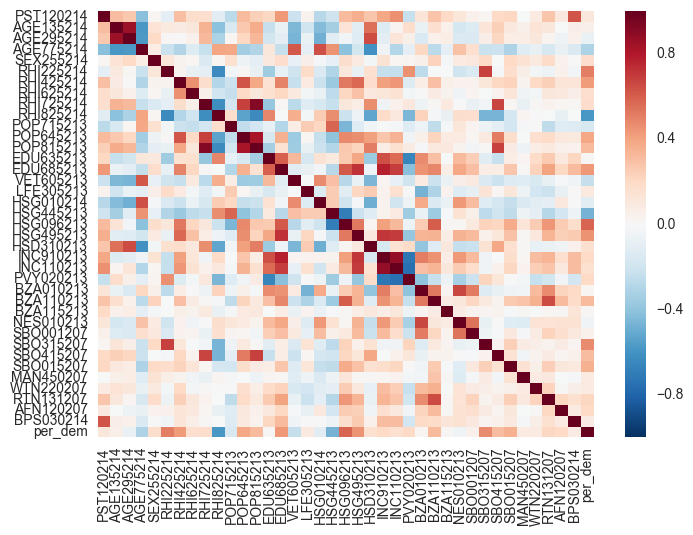

In [924]:
hd=header[0].copy()
hd[-1]='per_dem'
corr_tab=merged3[hd].corr()
sns.heatmap(corr_tab)
plt.show()

In [925]:
tmp=corr_tab['per_dem'].sort_values()
tmp=tmp[abs(tmp)>0.4]
del tmp['per_dem']
pd.merge(pd.DataFrame({0:tmp.index,2:tmp}),header,on=0)

,0,2,1
0,RHI825214,-0.581683,"White alone, not Hispanic or Latino, percent, ..."
1,HSG445213,-0.469334,"Homeownership rate, 2009-2013"
2,RHI425214,0.422325,"Asian alone, percent, 2014"
3,EDU685213,0.436008,"Bachelor's degree or higher, percent of person..."
4,HSG495213,0.447481,"Median value of owner-occupied housing units, ..."
5,SBO315207,0.469460,"Black-owned firms, percent, 2007"
6,RHI225214,0.511018,"Black or African American alone, percent, 2014"
7,HSG096213,0.583146,"Housing units in multi-unit structures, percen..."


In [926]:
pairs=[]
for i,r in corr_tab.iterrows():
    for j in r.index:
        if (abs(r[j])>0.8) and (i<j):
            pairs.append(sorted([i,j]))
for p in pairs:
    print(str(header[header[0]==p[0]][1].values[0])+" | "+str(header[header[0]==p[1]][1].values[0]))

Persons under 5 years, percent, 2014 | Persons under 18 years, percent, 2014
Foreign born persons, percent, 2009-2013 | Language other than English spoken at home, pct age 5+, 2009-2013
Language other than English spoken at home, pct age 5+, 2009-2013 | Hispanic or Latino, percent, 2014
Median household income, 2009-2013 | Per capita money income in past 12 months (2013 dollars), 2009-2013


In [928]:
import sklearn
import sklearn.decomposition

In [929]:
def inv_sigm(x):
    return np.log((x+10**-100)/(1-x-10**-100))
def sigm(x):
    return np.exp(x)/(1+np.exp(x))

In [930]:
y=merged3['per_dem']

In [952]:
pca=sklearn.decomposition.PCA()
scaler=sklearn.preprocessing.StandardScaler()
X1=pca.fit_transform(merged3[header[0]])
X=scaler.fit_transform(X1)
y_mean=y.mean()
y_std=y.std()
y=(y-y_mean)/y_std

In [954]:
rot_matrix=pd.DataFrame(pca.components_,columns=header[0])

In [955]:
X_train, X_test, y_train, y_test = sklearn.cross_validation.train_test_split(X,y,test_size=0.33)

In [956]:
lin=linear_model.Lasso(alpha=0.05)

In [957]:
fit=lin.fit(X_train,y_train)

In [958]:
pred_train=fit.predict(X_train)
pred_test=fit.predict(X_test)
pred_all=fit.predict(X)

In [937]:
#pd.DataFrame({'vals':fit.coef_,'code':header[0],'descr':header[1]}).sort_values(by='vals')

In [959]:
coeffs=pd.Series(fit.coef_,range(len(fit.coef_))).sort_values()
most_neg=coeffs.iloc[:5]
most_pos=coeffs.iloc[-5:]

In [961]:
most_neg_mat=rot_matrix.T[most_neg.index]
for x in most_neg_mat:
    #ser=most_neg_mat[x].abs().sort_values()[::-1][:10]
    print('-----')
    print(coeffs[x]**2)
    d1=pd.DataFrame(most_neg_mat[x])
    d1.columns=['vals']
    d1['key']=abs(d1.vals)
    d1=d1.sort_values(by='key',ascending=False)[:5]
    d1[0]=d1.index
    mg=pd.merge(d1,header,on=0)
    mg=mg.drop('key',1)
    print(mg)

-----
0.147247457335
       vals          0                                                  1
0 -0.992614  HSG495213  Median value of owner-occupied housing units, ...
1 -0.107138  INC110213                 Median household income, 2009-2013
2 -0.051174  INC910213  Per capita money income in past 12 months (201...
3 -0.023595  RTN131207                      Retail sales per capita, 2007
4 -0.008024  POP060210                   Population per square mile, 2010
-----
0.140047902639
       vals          0                                                  1
0  0.618374  RHI825214  White alone, not Hispanic or Latino, percent, ...
1 -0.510720  HSD310213                   Persons per household, 2009-2013
2 -0.346883  RHI725214                  Hispanic or Latino, percent, 2014
3 -0.294600  POP815213  Language other than English spoken at home, pc...
4 -0.227094  RHI225214     Black or African American alone, percent, 2014
-----
0.123960063821
       vals          0                           

In [962]:
most_pos_mat=rot_matrix.T[most_pos.index]
for x in most_pos_mat.T[::-1].T:
    #ser=most_neg_mat[x].abs().sort_values()[::-1][:10]
    print('-----')
    print(coeffs[x]**2)
    d1=pd.DataFrame(most_pos_mat[x])
    d1.columns=['vals']
    d1['key']=abs(d1.vals)
    d1=d1.sort_values(by='key',ascending=False)[:5]
    d1[0]=d1.index
    mg=pd.merge(d1,header,on=0)
    mg=mg.drop('key',1)
    print(mg)

-----
0.0142048131153
       vals          0                                                  1
0 -0.457631  RHI725214                  Hispanic or Latino, percent, 2014
1  0.407835  POP715213  Living in same house 1 year & over, percent, 2...
2  0.319200  POP815213  Language other than English spoken at home, pc...
3  0.270956  HSG096213  Housing units in multi-unit structures, percen...
4 -0.247886  RHI225214     Black or African American alone, percent, 2014
-----
0.0109861610095
       vals          0                                                  1
0  0.625896  HSG010214                                Housing units, 2014
1  0.571847  BZA110213                  Private nonfarm employment,  2013
2  0.374992  HSG096213  Housing units in multi-unit structures, percen...
3  0.203082  EDU685213  Bachelor's degree or higher, percent of person...
4 -0.159750  HSG445213                      Homeownership rate, 2009-2013
-----
0.00647015694306
       vals          0                       

In [964]:
np.sqrt(np.mean((pred_train-y_train)**2))*y_std

0.082523992323580334

In [965]:
np.sqrt(np.mean((pred_test-y_test)**2))*y_std

0.086302856409822243

In [943]:
merged3['prediction']=sigm(pred_all)

In [944]:
merged3['discr']=merged3['prediction']-merged3['per_dem']

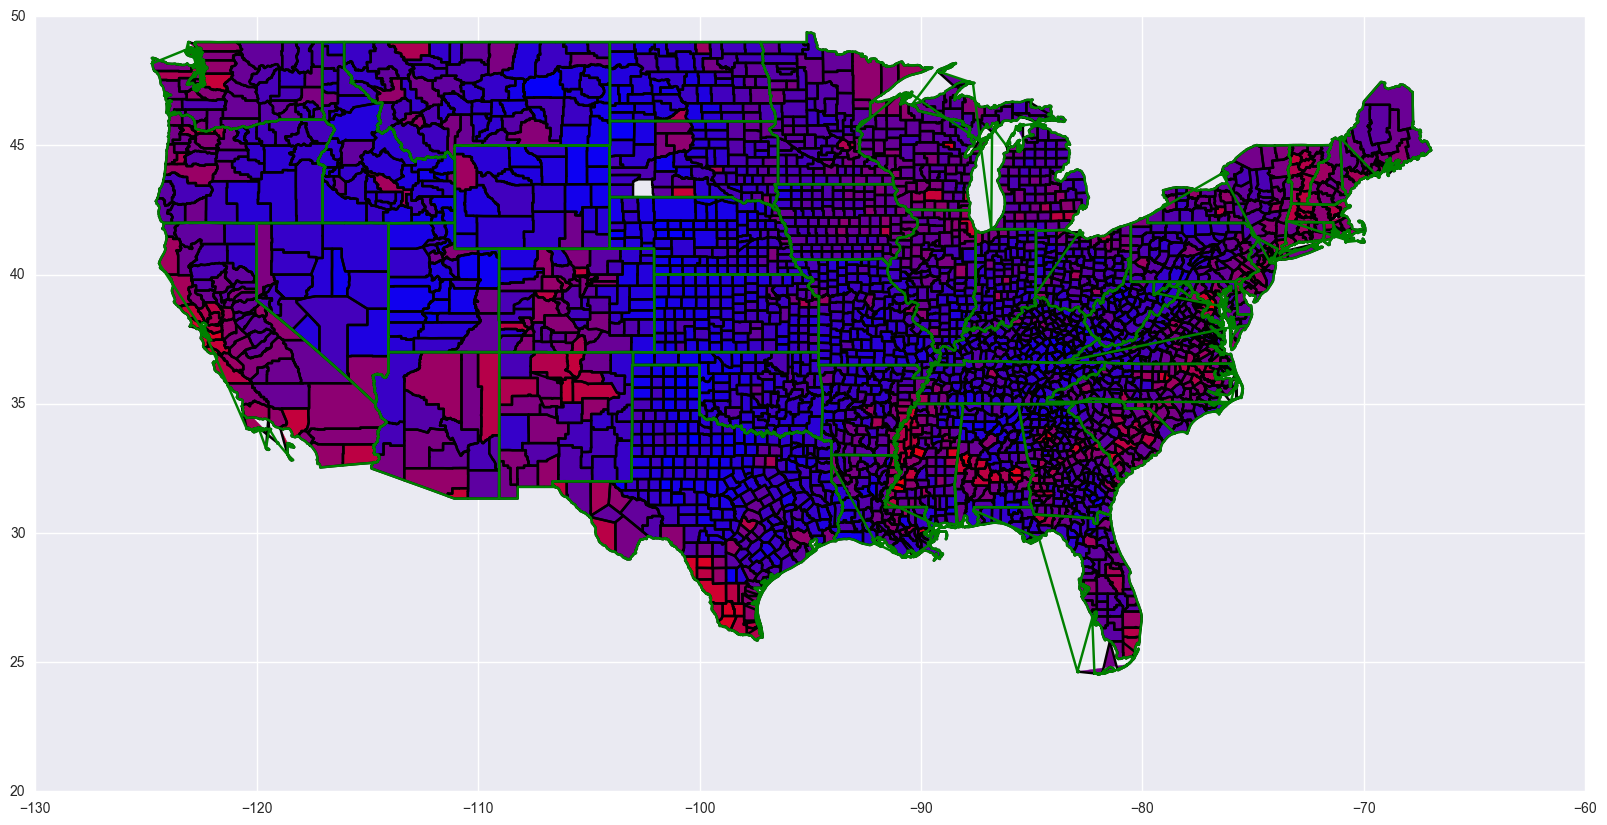

In [945]:
draw_usa(merged3,'discr')

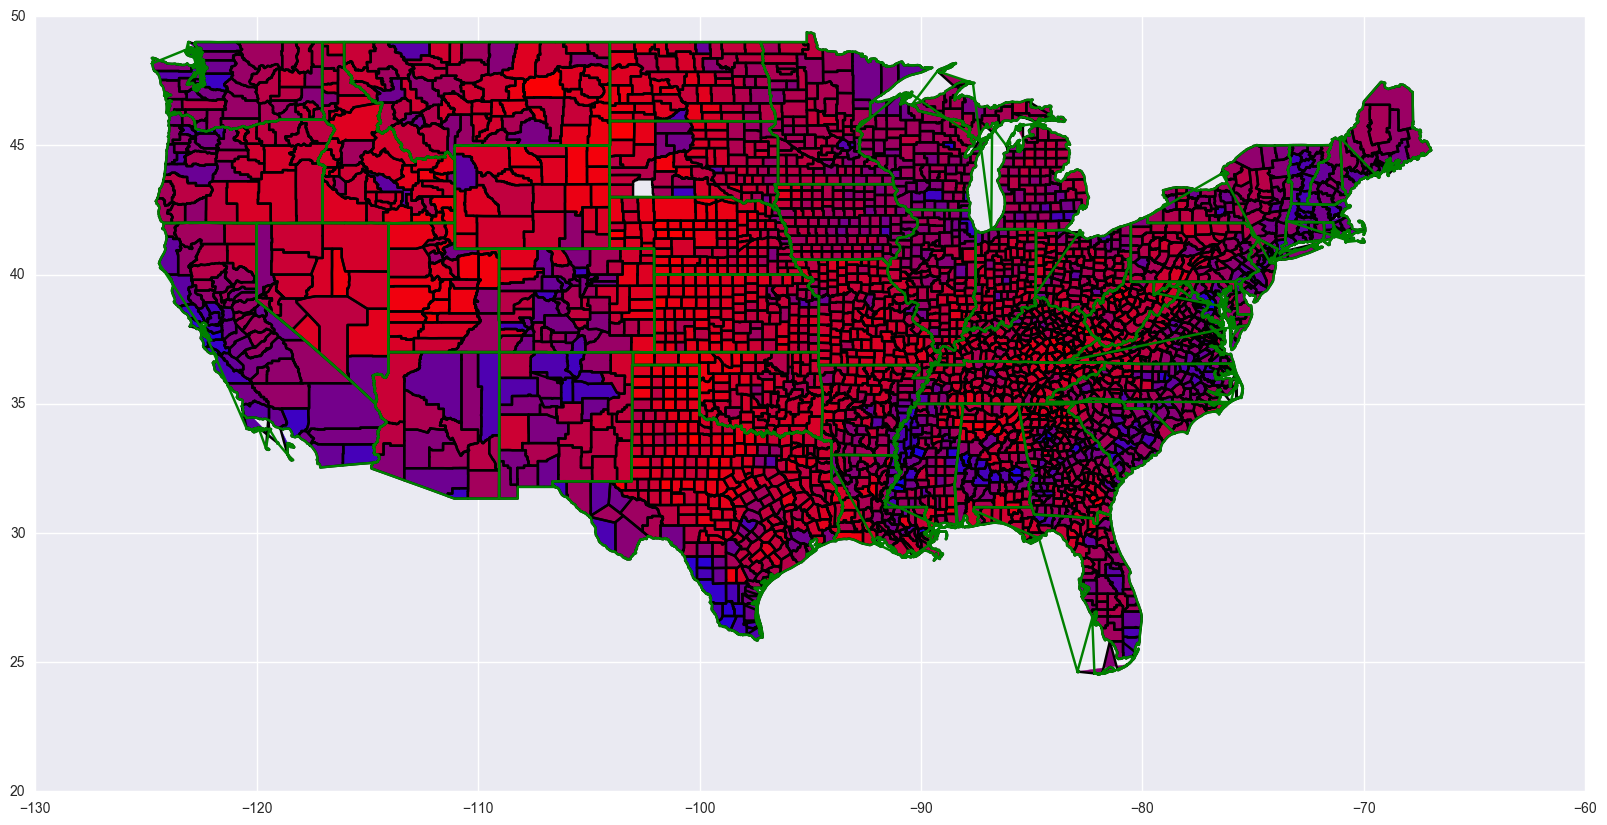

In [177]:
draw_usa(merged3,'per_dem')

In [872]:
merged3['PST045214_1']=merged3['PST045214']

In [882]:
merged3['PST045214_1']=merged3['PST045214_1'].apply(lambda x: x if x<300000 else 300000)

In [887]:
merged3['PST045214'].median()

25961.0

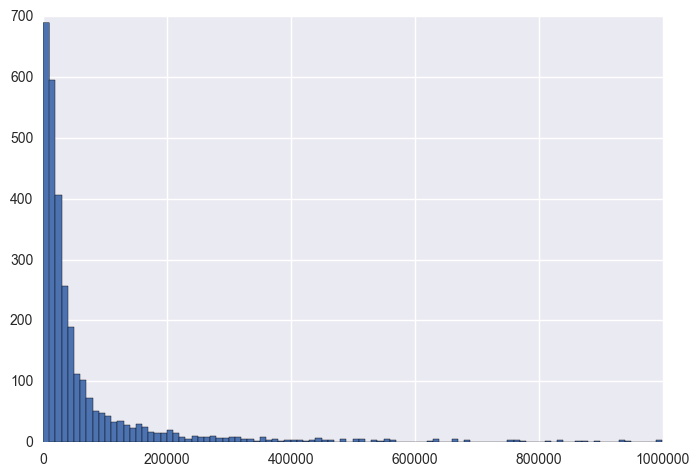

In [875]:
merged3['PST045214'][merged3['PST045214']<1000000].hist(bins=100)
plt.show()

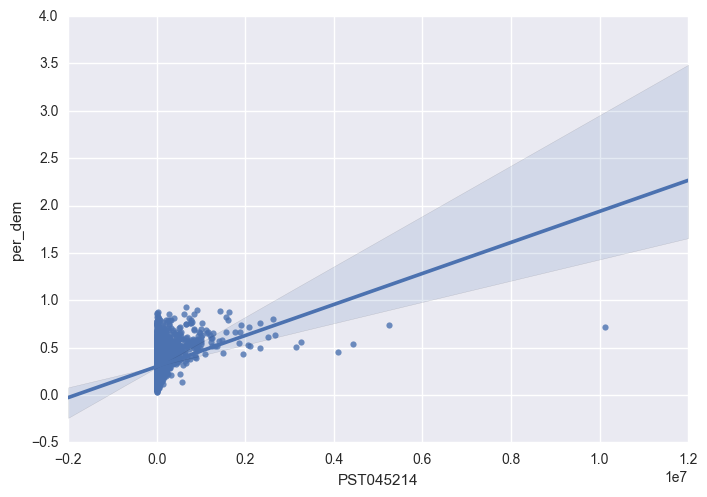

In [886]:
sns.regplot(merged3['PST045214'],merged3['per_dem'])
plt.show()

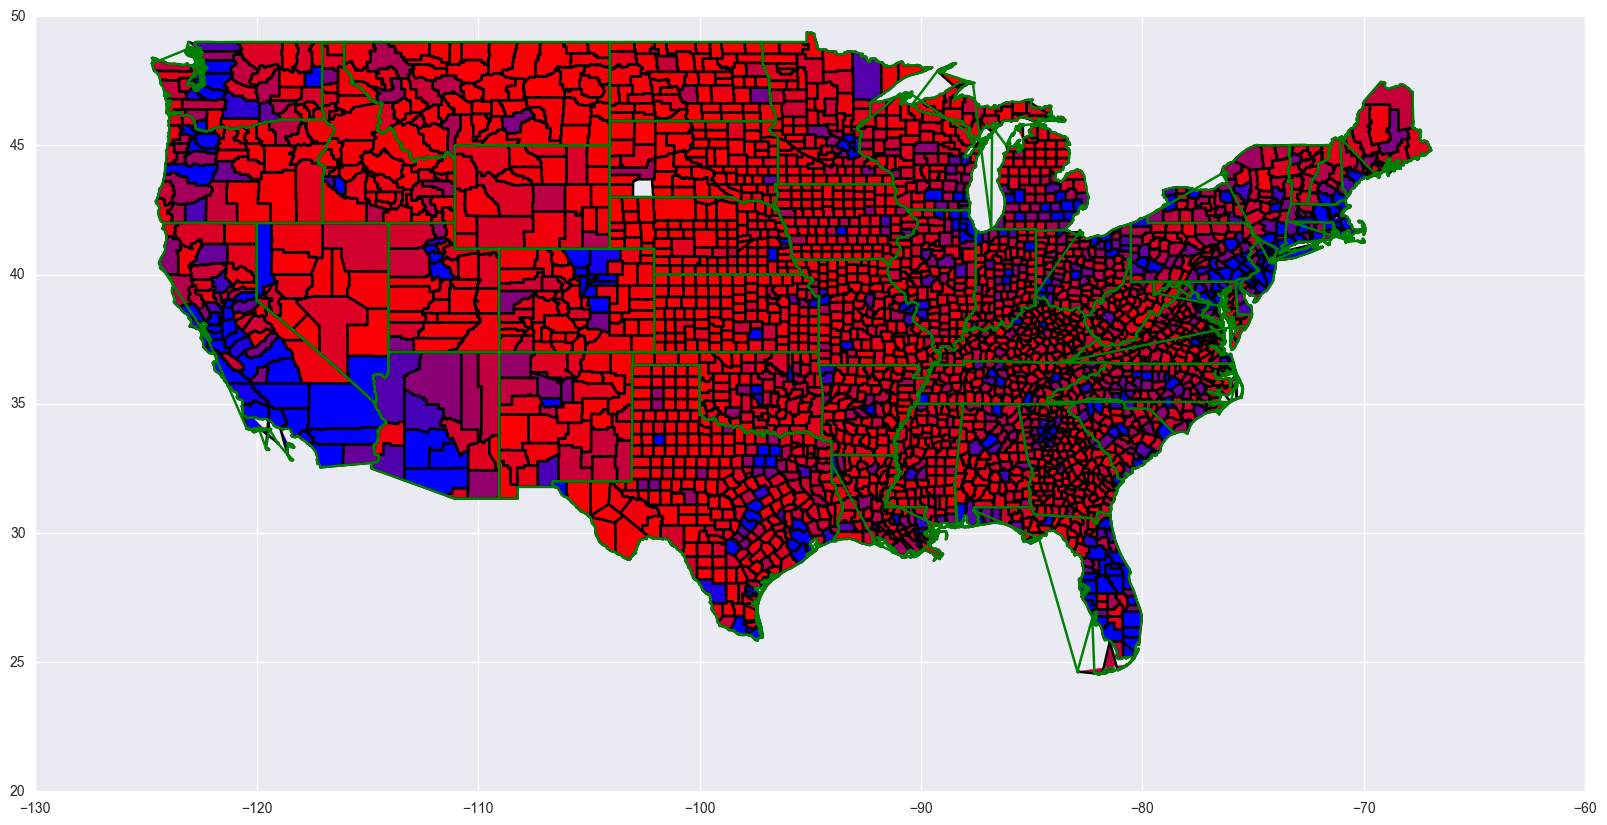

In [883]:
draw_usa(merged3,'PST045214_1')

## France

In [ ]:
#https://github.com/lexman/carte-de-mon-departement/blob/master/README.md

In [396]:
el2012_circ=pd.read_csv("cdsp_presi2012t2_circ.csv",sep=';')

In [400]:
el2012_circ.columns

Index([u'Code du département', u'Libellé du département',
       u'Code de la circonscription', u'Inscrits', u'Votants', u'Exprimés',
       u'Blancs et nuls', u'François HOLLANDE (PS)', u'Nicolas SARKOZY (UMP)'],
      dtype='object')

In [405]:
el2012_circ['per_ump']=el2012_circ[u'Nicolas SARKOZY (UMP)']/el2012_circ['Inscrits']

In [301]:
dep_shapes_file=shapefile.Reader("departements.shp")
dep_shapes=dep_shapes_file.shapes()
dep_col_names=[x[0] for x in dep_shapes_file.fields][1:]
dep_records=pd.DataFrame([dict(zip(*[dep_col_names, x])) for x in dep_shapes_file.records()])
dep_records['points']=[x.points for x in dep_shapes]

In [308]:
circ_shapes=pd.read_csv("toxicode_circonscriptions_legislatives.csv")

In [313]:
test=circ_shapes.loc[0].kml_shape

In [350]:
def to_float(x):
    try:
        return float(x)
    except(ValueError,TypeError):
        return np.nan
        
def parse(test):
    return [map(to_float,x.split(",")) for x in re.sub("\<[a-zA-z\/]+\>","",test).split(" ")] 
    

In [426]:
el2012_circ.columns=['department', u'Libellé du département',
       'numero', u'Inscrits', u'Votants', u'Exprimés',
       u'Blancs et nuls', u'François HOLLANDE (PS)', u'Nicolas SARKOZY (UMP)',
       u'per_ump']

In [351]:
circ_shapes['points']=[parse(x) if not pd.isnull(x) else [] for x  in circ_shapes.kml_shape]

In [475]:
def transform_dep_label(arr):
    arr[arr=='ZZ']=0
    arr[arr=='2A']=1000
    arr[arr=='2B']=1000

In [477]:
transform_dep_label(el2012_circ.department)
transform_dep_label(circ_shapes.department)
transform_dep_label(dep_records.code)

In [471]:
french_overseas=[971,972,973,974,976,0,1000]

In [381]:
circ_shapes_metro=circ_shapes[~np.array([x in french_overseas for x in  circ_shapes.department.astype(int)])]

In [467]:
circ_shapes_metro['department']=circ_shapes_metro['department'].astype(int)
el2012_circ['department']=el2012_circ['department'].astype(int)

/Users/grisha.oryol/anaconda/envs/cloned/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [468]:
circ_merged=pd.merge(circ_shapes_metro,el2012_circ,on=['department','numero'])

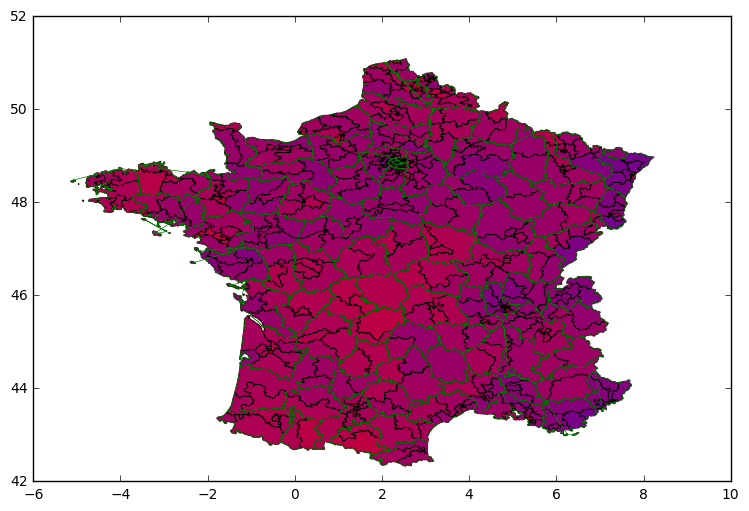

In [500]:
#fig=plt.figure(figsize=(10*0.75,10*0.75))
for i,row in circ_merged.iterrows():
        plt.fill(*zip(*row.points),color=np.array([1,0,0])*(1-row['per_ump'])+np.array([0,0,1])*row['per_ump'])
        plt.plot(*zip(*row.points),color='black',linewidth=0.5)
for i,row in dep_records.iterrows():
    if not(int(row.code) in french_overseas):
        ax=plt.plot(*zip(*row.points),color='green',linewidth=0.5)
ax[0].figure.set_size_inches(ax[0].figure.get_size_inches()*1.5)
plt.show()